# The ESGF Virtual Aggregation

The ESGF Virtual Aggregation is an analysis of a new proposed data workflow and a companion dataset that aims to advance the sharing and reuse of scientific climate data stored in the Earth System Grid Federation. The ESGF holds several petabytes of data distributed between data centers around the globe and the data workflow proposal enhances the federation, beyond file search and download, by allowing remote climate data analysis on data analysis ready, virtually aggregated, climate datasets. The companion dataset serves as demonstration of a viable implementation of the data workflow. The ESGF Virtual Aggregation analysis serves as a test case for the viability of the data workflow and provides the basis for discussions on the future of the ESGF infrastructure, regarding the continuity of federation services such as OpenDAP and the Search REST API.

Find all the data available in the [TDS catalog](https://hub.ipcc.ifca.es/thredds/catalog/esgeva/catalog.html). Just copy the OPeNDAP url from the TDS.

In [1]:
import xarray
import dask

In [2]:
dask.config.set(scheduler="processes")

## A small example

Find the NcML [here](https://hub.ipcc.ifca.es/thredds/fileServer/esgeva/ensemble/CMIP6/ScenarioMIP/day/CMIP6_ScenarioMIP_CNRM-CERFACS_CNRM-CM6-1_ssp245_day_gr_v20190410/CMIP6_ScenarioMIP_CNRM-CERFACS_CNRM-CM6-1_ssp245_day_tas_gr_v20190410_esg1.umr-cnrm.fr.ncml).

In [3]:
dataset = "https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/ScenarioMIP/day/CMIP6_ScenarioMIP_CNRM-CERFACS_CNRM-CM6-1_ssp245_day_gr_v20190410/CMIP6_ScenarioMIP_CNRM-CERFACS_CNRM-CM6-1_ssp245_day_tas_gr_v20190410_esg1.umr-cnrm.fr.ncml"

ds = xarray.open_dataset(dataset).chunk({"variant_label": 1, "time": 300})
tas = ds["tas"]
tas

<xarray.DataArray 'tas' (variant_label: 5, time: 31411, lat: 128, lon: 256)>
dask.array<xarray-tas, shape=(5, 31411, 128, 256), dtype=float32, chunksize=(1, 300, 128, 256), chunktype=numpy.ndarray>
Coordinates:
  * lat            (lat) float64 -88.93 -87.54 -86.14 ... 86.14 87.54 88.93
  * lon            (lon) float64 0.0 1.406 2.812 4.219 ... 355.8 357.2 358.6
    height         float64 ...
  * time           (time) datetime64[ns] 2015-01-01T12:00:00 ... 2100-12-31T1...
  * variant_label  (variant_label) |S64 b'r2i1p1f2' b'r3i1p1f2' ... b'r6i1p1f2'
Attributes:
    long_name:           Near-Surface Air Temperature
    _CoordinateAxes:     variant_label height time lat lon
    online_operation:    average
    cell_methods:        area: time: mean
    interval_operation:  900 s
    interval_write:      1 d
    standard_name:       air_temperature
    description:         Near-Surface Air Temperature
    history:             none
    units:               K
    cell_measures:       area: areacella
    _ChunkSizes:         [  1 128 256]

In [5]:
%time m = ds["tas"].mean(["lat", "lon"]).compute()

CPU times: user 360 ms, sys: 35.9 ms, total: 396 ms
Wall time: 8min 18s


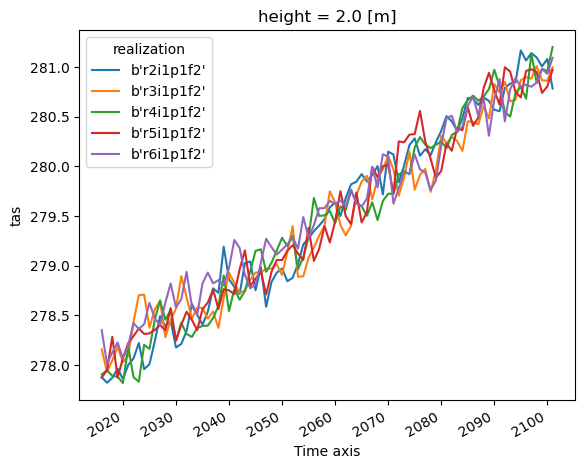

In [6]:
m.resample({"time": "Y"}).mean().plot.line(x="time")

# A larger example

How aggregations perform on datasets with more ensembles and files? The following example contains 87 files and 29 ensembles (3 files in each time series). Also, we will compare the multiple replicas to test the performance on different data nodes.

Find the NcML [here](https://hub.ipcc.ifca.es/thredds/fileServer/esgeva/ensemble/CMIP6/CMIP/day/CMIP6_CMIP_NCC_NorCPM1_historical_day_gn_v20191005/CMIP6_CMIP_NCC_NorCPM1_historical_day_tas_gn_v20191005_noresg.nird.sigma2.no.ncml).

In [7]:
dataset = "https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/CMIP/day/CMIP6_CMIP_NCC_NorCPM1_historical_day_gn_v20191005/CMIP6_CMIP_NCC_NorCPM1_historical_day_tas_gn_v20191005_noresg.nird.sigma2.no.ncml"

ds = xarray.open_dataset(dataset)
ds

<xarray.Dataset>
Dimensions:           (lat: 96, bnds: 2, lon: 144, time: 29200,
                       variant_label: 29, nfiles: 87, file: 2)
Coordinates:
  * lat               (lat) float64 -90.0 -88.11 -86.21 ... 86.21 88.11 90.0
  * lon               (lon) float64 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
    height            float64 ...
  * time              (time) object 1950-01-01 12:00:00 ... 2029-12-31 12:00:00
  * variant_label     (variant_label) |S64 b'r11i1p1f1' ... b'r9i1p1f1'
Dimensions without coordinates: bnds, nfiles, file
Data variables:
    lat_bnds          (lat, bnds) float64 ...
    lon_bnds          (lon, bnds) float64 ...
    time_bnds         (time, bnds) object ...
    further_info_url  (nfiles, file) |S64 ...
    tracking_id       (nfiles, file) |S64 ...
    tas               (variant_label, time, lat, lon) float32 ...
Attributes: (12/56)
    Conventions:               
    activity_id:               CMIP
    branch_method:             no parent
    branch_time:               674885.0
    branch_time_in_child:      674885.0
    branch_time_in_parent:     674885.0
    ...                        ...
    size:                      2147483647
    size_human:                26.2 GiB
    __info__:                  Virtual dataset generated by the ESGF Virtual ...
    __license__:               This is a derived dataset product from ESGF, s...
    version:                   v20191005
    replica:                   0

In [8]:
tas = ds["tas"].chunk({"variant_label": 1, "time": 900})
tas

<xarray.DataArray 'tas' (variant_label: 29, time: 29200, lat: 96, lon: 144)>
dask.array<xarray-<this-array>, shape=(29, 29200, 96, 144), dtype=float32, chunksize=(1, 900, 96, 144), chunktype=numpy.ndarray>
Coordinates:
  * lat            (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon            (lon) float64 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
    height         float64 ...
  * time           (time) object 1950-01-01 12:00:00 ... 2029-12-31 12:00:00
  * variant_label  (variant_label) |S64 b'r11i1p1f1' ... b'r9i1p1f1'
Attributes:
    long_name:        Near-Surface Air Temperature
    _CoordinateAxes:  variant_label height time lat lon
    standard_name:    air_temperature
    comment:          near-surface (usually, 2 meter) air temperature
    units:            K
    original_name:    TREFHT
    cell_methods:     area: time: mean
    cell_measures:    area: areacella
    history:          2019-10-07T14:10:55Z altered by CMOR: Treated scalar di...
    _ChunkSizes:      [  1  96 144]

In [9]:
print("Size in disk: {}.\nSize in memory {} GiB.\nFiles: {}.\nEnsembles: {}.".format(
    ds.attrs["size_human"],
    round(tas.size * tas.dtype.itemsize / 2**30,2),
    ds.sizes["nfiles"],
    tas["variant_label"].shape[0]))

Size in disk: 26.2 GiB.
Size in memory 43.61 GiB.
Files: 87.
Ensembles: 29.


In [10]:
%time a = tas.mean(["lat", "lon"]).compute()

CPU times: user 419 ms, sys: 44.4 ms, total: 463 ms
Wall time: 21min 32s
